## Part 1

# Quantum Cloud, Near-Time Compute
<br>
<br>

You can find a copy of this presentation at

https://github.com/grossiM/IANUA/tree/main

michele.grossi@cern.ch

## Introduction to Qiskit

Qiskit is a Python-based, open source software development toolkit (SDK) for working with quantum computers.  It can be used at the level of circuits, algorithms, and application modules.

### Installing Qiskit

Anaconda or a pyenv is recommended to manage all dependencies.

*Command:* `pip install qiskit`, `pip install 'qiskit-terra[visualization]'`, `pip install matplotlib`, `pip install qiskit_ibm_provider`

*Python version:* 3.9+


### Typical Qiskit Workflow

**Build**: Design a quantum circuit(s) that represents the problem you are considering.

**Compile**: Compile circuits for a specific quantum backend, e.g., a quantum system or classical simulator.

**Run**: Run the compiled circuits on the specified quantum backend.

**Analyze**: Compute summary statistics and visualize the results of the experiments.


### Step 0 : check package version

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

#### Step 1: Build the Circuit

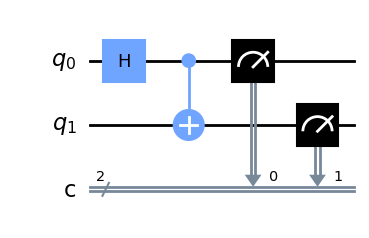

In [2]:
from qiskit import QuantumCircuit

# Create a quantum circuit with 2 qubits and 2 classical bits
circuit = QuantumCircuit(2, 2)

# Add a Hadamard gate on qubit 0
circuit.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)

# Measure qubits 0 and 1 onto classical bits 0 and 1
circuit.measure([0, 1], [0, 1])

# Draw the circuit
circuit.draw('mpl')

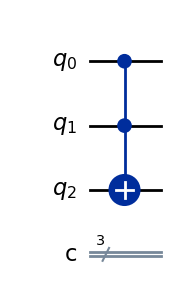

In [3]:
circuit = QuantumCircuit(3, 3)
circuit.toffoli(0,1,2)
circuit.draw( 'mpl', style='iqx')#fold=20 style=large_font

#### Step 1 bis: visualize the matrix generated by the circuit

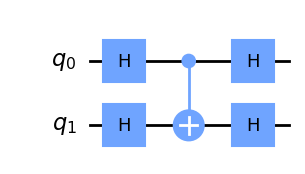

<IPython.core.display.Latex object>

In [4]:
from qiskit import assemble, Aer
from qiskit.visualization import array_to_latex

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.h(0)
qc.h(1)
display(qc.draw('mpl')) 

usim = Aer.get_backend('unitary_simulator')

unitary = usim.run(qc).result().get_unitary()
array_to_latex(unitary, prefix="\\text{Circuit = }\n")

#### Step 2: Compile the Circuit

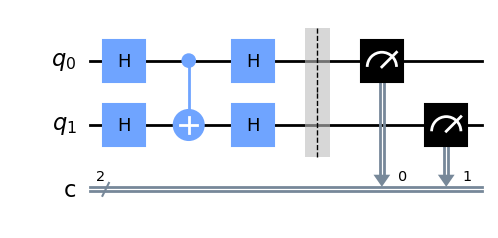

In [5]:
#before compiling we complete the circuit with measurement

# Create a Quantum Circuit
meas = QuantumCircuit(2, 2)
meas.barrier(range(2))
# map the quantum measurement to the classical bits
meas.measure(range(2), range(2))

# The Qiskit circuit object supports composition.
# Here the meas has to be first and front=True (putting it before)
# as compose must put a smaller circuit into a larger one.
qc = meas.compose(qc, range(2), front=True)

#drawing the circuit
qc.draw('mpl')

In [6]:
from qiskit import transpile
from qiskit.providers.aer import AerSimulator

# Use a local simulator
simulator = AerSimulator()

# Compile the circuit down to low-level instructions supported by the backend
compiled_circuit = transpile(qc, simulator)


#### Step 3: Run the Circuit

In [7]:
# Execute the circuit on the qasm simulator
# shots defines the number of executions
job = simulator.run(compiled_circuit, shots=1000)

# Grab results from the job
result = job.result()

#### Step 4: Analyze and Visualize the Result

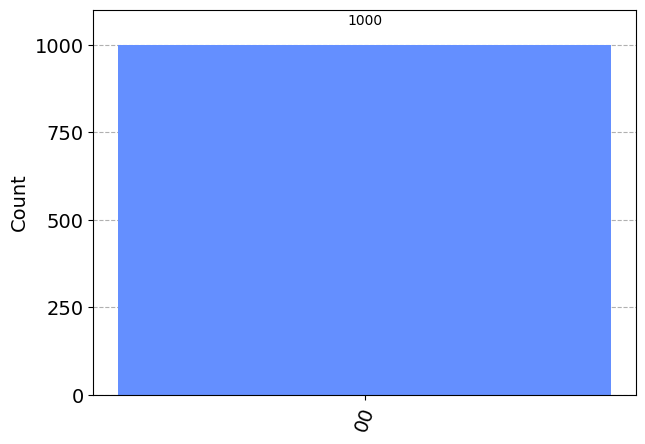

In [8]:
from qiskit.visualization import plot_histogram

# Get summarized counts of qubit measurements
counts = result.get_counts()

# Plot a histogram
# "00" means both qubits were measured 0; "11" means both were measured 1.
plot_histogram(counts)

### Extra: some additional functions

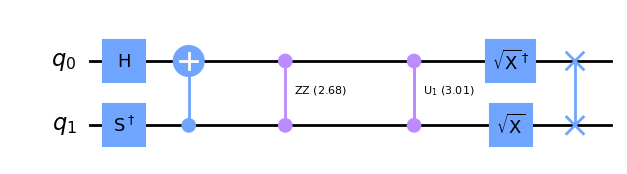

In [9]:
#Import the random circuit class
from qiskit.circuit.random import random_circuit
#Create two random circuits, each with 2 qubit registers and random #gate operator counts.
qc1 = random_circuit(2,2)
qc2 = random_circuit(2,4)
#Concatenate the two random circuits
qc = qc1.compose(qc2)
#Draw the circuit
qc.draw('mpl')

In [10]:
#Define function to print circuit properties:
def print_circuit_props(qc):
    width = qc.width()
    depth = qc.depth()
    num_operators = qc.count_ops()
    circuit_size = qc.size()
    print('Width = ',width) 
    print('Depth = ', depth)
    print('Circuit size = ',circuit_size)
    print('Number of operators = ', num_operators)

In [11]:
#Pass our quantum circuit to print out the circuit properties
print_circuit_props(qc)

Width =  2
Depth =  6
Circuit size =  8
Number of operators =  OrderedDict([('h', 1), ('sdg', 1), ('cx', 1), ('rzz', 1), ('cu1', 1), ('sxdg', 1), ('sx', 1), ('swap', 1)])


Width =  3
Depth =  1
Circuit size =  1
Number of operators =  OrderedDict([('ccx', 1)])


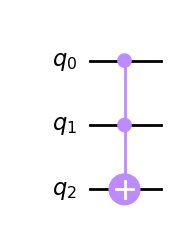

In [12]:
qc = QuantumCircuit(3)
qc.ccx(0,1,2)
#Print out the circuit properties
print_circuit_props(qc)
qc.draw('mpl')

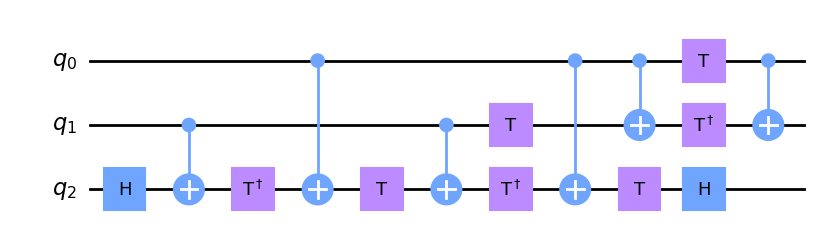

In [13]:
qc.decompose().draw('mpl')

In [14]:
#Print out the circuit properties
print_circuit_props(qc.decompose())

Width =  3
Depth =  11
Circuit size =  15
Number of operators =  OrderedDict([('cx', 6), ('t', 4), ('tdg', 3), ('h', 2)])


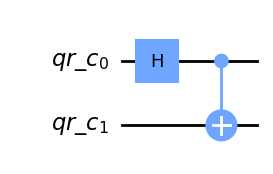

In [15]:
from qiskit import QuantumRegister
#Create a custom two-qubit composite gate
#Create the quantum register
qr = QuantumRegister(2, name='qr_c')
#Generate quantum circuit which will make up the composite gate
comp_qc = QuantumCircuit(qr, name='my-composite')
#Add any gates you wish to your composite gate
comp_qc.h(0)
comp_qc.cx(0, 1)
#Create the composite instructions by converting 
#the QuantumCircuit to a list of Instructions
composite_inst = comp_qc.to_instruction()
#Draw the circuit which will represent the composite gate
comp_qc.draw('mpl')

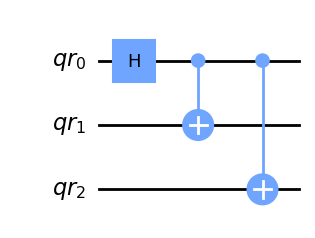

In [16]:
#Create another 3-qubit circuit 
qr2 = QuantumRegister(3, 'qr')
#Create a quantum circuit using the quantum register
qc = QuantumCircuit(qr2)
#Add any arbitrary gates that would represent the function 
#of the composite gate 
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
#Draw the composite circuit
qc.draw('mpl')

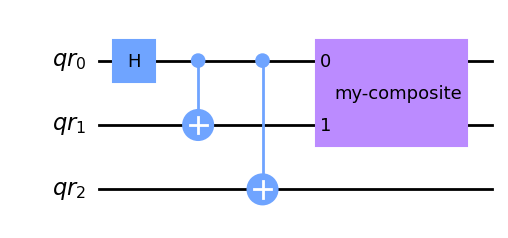

In [17]:
#Append your composite gate to the specified qubits. 
qc.append(composite_inst, [qr2[0], qr2[1]])
#Draw the complete circuit
qc.draw('mpl')

## Parameterized circuits

In [18]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)


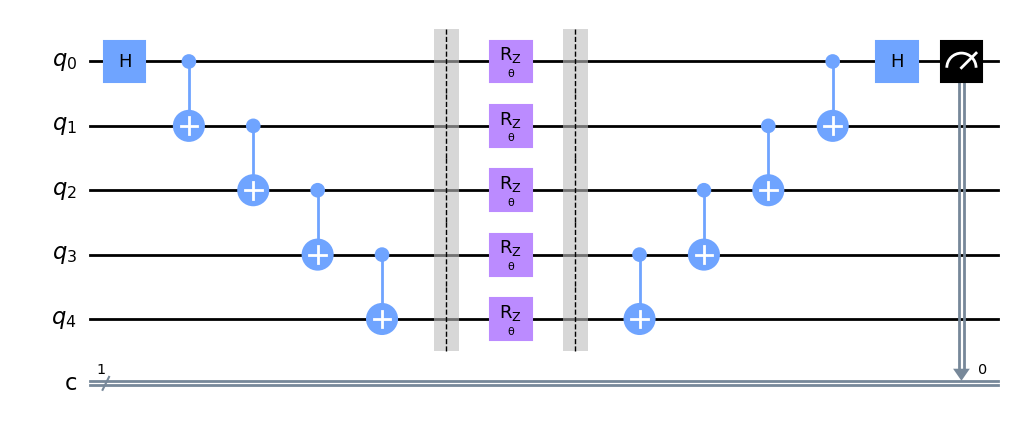

In [19]:
qc.draw('mpl')

### Binding parameters to values
All circuit parameters must be bound before sending the circuit to a backend. This can be done as follows:
- The `bind_parameters` method accepts a dictionary mapping `Parameter`s to values, and returns a new circuit with each parameter replaced by its corresponding value. Partial binding is supported, in which case the returned circuit will be parameterized by any `Parameter`s that were not mapped to a value.

In [20]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

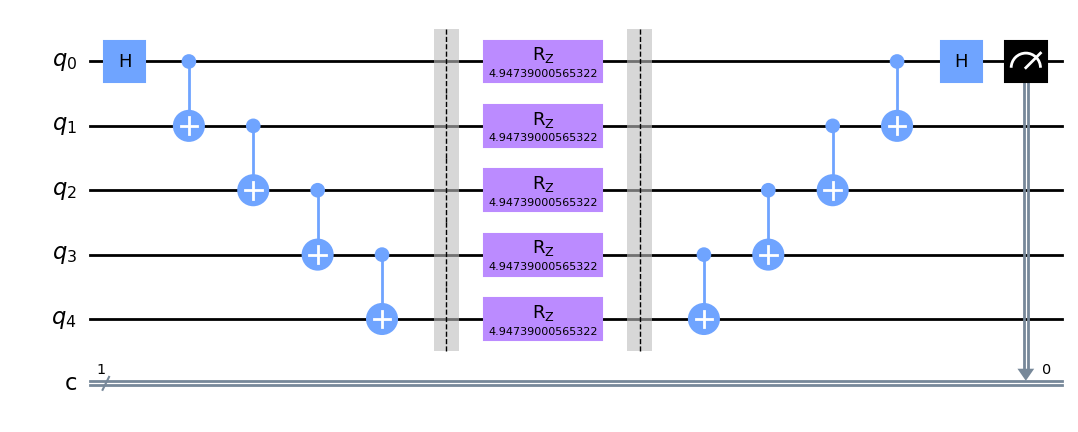

In [22]:
circuits[100].draw('mpl')

In [23]:
from qiskit import BasicAer, transpile
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

In the example circuit, we apply a global $R_z(\theta)$ rotation on a five-qubit entangled state, and so expect to see oscillation in qubit-0 at $5\theta$.

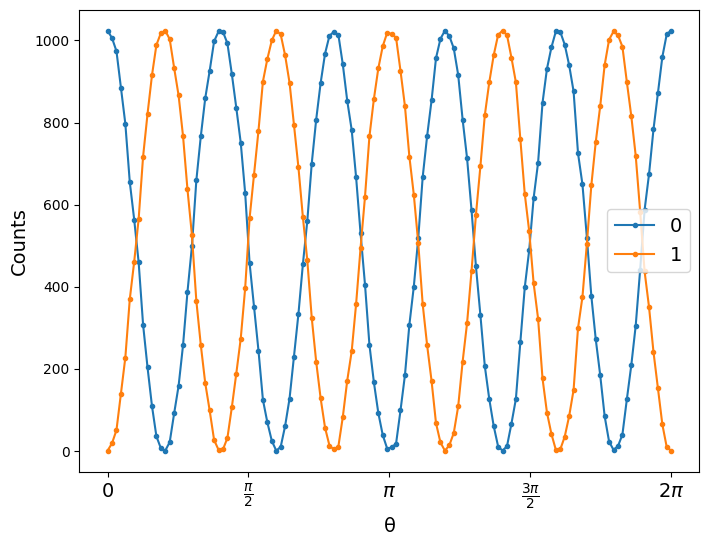

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1') 

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

NB To insert a subcircuit under a different parameterization, the `to_instruction` method accepts an optional argument (`parameter_map`) which, when present, will generate instructions with the source parameter replaced by a new parameter.

In [25]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])

In [26]:
print(larger_qc.draw())

        ┌────────────────┐
q644_0: ┤0               ├
        │                │
q644_1: ┤1 oracle(theta) ├
        │                │
q644_2: ┤2               ├
        └┬──────────────┬┘
q644_3: ─┤0             ├─
         │              │ 
q644_4: ─┤1 oracle(phi) ├─
         │              │ 
q644_5: ─┤2             ├─
        ┌┴──────────────┴┐
q644_6: ┤0               ├
        │                │
q644_7: ┤1 oracle(gamma) ├
        │                │
q644_8: ┤2               ├
        └────────────────┘


In [27]:
print(larger_qc.decompose().draw())

        ┌───────────┐                                    
q644_0: ┤ Rz(theta) ├──■─────────────────────────────────
        └───────────┘┌─┴─┐┌───────────┐                  
q644_1: ─────────────┤ X ├┤ Rz(theta) ├──■───────────────
                     └───┘└───────────┘┌─┴─┐┌───────────┐
q644_2: ───────────────────────────────┤ X ├┤ Rz(theta) ├
         ┌─────────┐                   └───┘└───────────┘
q644_3: ─┤ Rz(phi) ├───■─────────────────────────────────
         └─────────┘ ┌─┴─┐ ┌─────────┐                   
q644_4: ─────────────┤ X ├─┤ Rz(phi) ├───■───────────────
                     └───┘ └─────────┘ ┌─┴─┐ ┌─────────┐ 
q644_5: ───────────────────────────────┤ X ├─┤ Rz(phi) ├─
        ┌───────────┐                  └───┘ └─────────┘ 
q644_6: ┤ Rz(gamma) ├──■─────────────────────────────────
        └───────────┘┌─┴─┐┌───────────┐                  
q644_7: ─────────────┤ X ├┤ Rz(gamma) ├──■───────────────
                     └───┘└───────────┘┌─┴─┐┌───────────┐
q644_8: ──────

### Extra about visualization

In [28]:
# Will execute the circuit on the state vector (sv) simulator
# Returns state vector results, circuit diagram, and Bloch sphere 
from qiskit import Aer, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
def execute_circuit_sv(quantum_circuit):
    #Create a state vector simulator
    statevector_simulator = Aer.get_backend('statevector_simulator')
    #Execute the circuit on the simulator
    result = execute(quantum_circuit, statevector_simulator).result()
    #Assign state vector results
    statevector_results  = result.get_statevector(quantum_circuit)
    #Draw the circuit diagram
    circuit_diagram = quantum_circuit.draw('mpl')
    #Draw the Bloch sphere result
    q_sphere = plot_state_qsphere(statevector_results)
    #Return the results, circuit diagram, and Bloch sphere
    return statevector_results, circuit_diagram, q_sphere

In [29]:
#H-gate 
#Create the single qubit circuit
qc = QuantumCircuit(1)
#Add an H gate to the qubit
qc.h(0)
#Execute the circuit and capture all the results
result, img, qsphere  = execute_circuit_sv(qc)

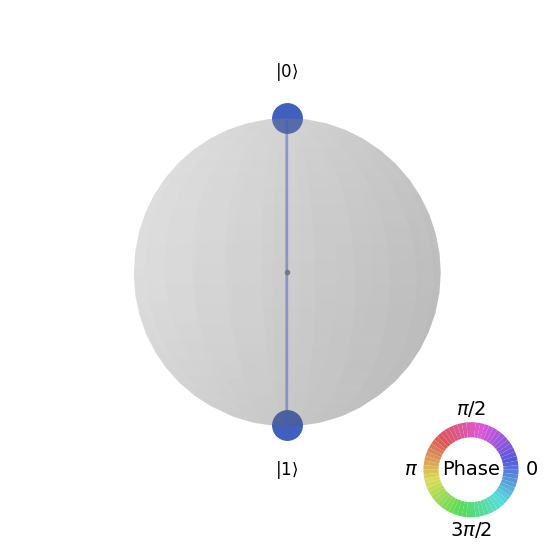

In [30]:
qsphere

In [31]:
#U3-gate
from math import pi
#Create a single qubit circuit
qc = QuantumCircuit(1)
#Add a U3 gate and rotate all parameters by pi/2, and apply it to the qubit
qc.u(pi/2, pi/2, pi/2, 0)
#Execute the circuit and capture all the results
result, img, qsphere = execute_circuit_sv(qc)

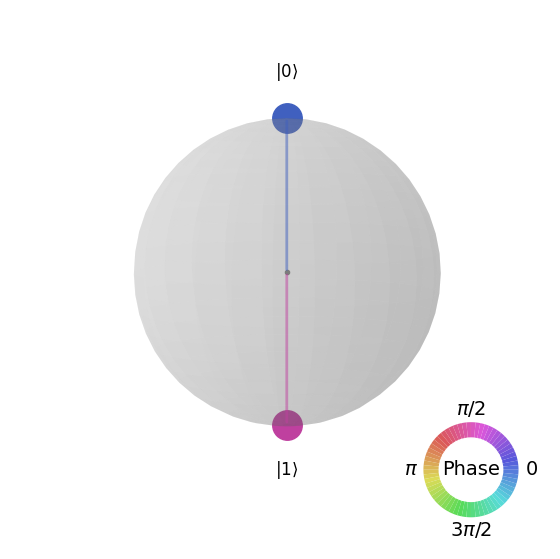

In [32]:
qsphere

#### Extra Features
https://medium.com/qiskit/learn-how-to-customize-the-appearance-of-your-qiskit-circuits-with-accessibility-in-mind-b9b59fc039f3

## Introduction to IBM Quantum

Offers access to cloud-based quantum computing services

- quantum processors
- simulators
- experiments
- tutorials

### Using Qiskit to access IBM Quantum services

Qiskit is designed to work with different providers. A _provider_ is any entity that provides quantum-related services that can be accessed using Qiskit. The most common service is quantum processors.


Before you can access IBM Quantum services, you need an IBM Quantum account. You can sign up for an account at https://quantum-computing.ibm.com/.

Once you have an account, you can grab your API token

<img src="images/token.png">

#### Initializing Your Account in Qiskit

In [34]:
# Import the module needed to access IBM Quantum
# Load your IBM Quantum account or enable the account if it's not previously saved.
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

For more details please have a look [here](https://research.ibm.com/blog/qiskit-runtime-for-useful-quantum-computing) and [tutorial](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html)

#### Running a Circuit on IBM Quantum Backend and Transpiling

In [35]:
provider.backends()

[<IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_oslo')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_washington')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibm_auckland')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>]

In [36]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

In [37]:
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler.passes import BasicSwap, LookaheadSwap, StochasticSwap

coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

circuit = QuantumCircuit(7)
circuit.h(3)
circuit.cx(0, 6)
circuit.cx(6, 0)
circuit.cx(0, 1)
circuit.cx(3, 1)
circuit.cx(3, 0)

coupling_map = CouplingMap(couplinglist=coupling)

bs = BasicSwap(coupling_map=coupling_map)
pass_manager = PassManager(bs)
basic_circ = pass_manager.run(circuit)

ls = LookaheadSwap(coupling_map=coupling_map)
pass_manager = PassManager(ls)
lookahead_circ = pass_manager.run(circuit)

ss = StochasticSwap(coupling_map=coupling_map)
pass_manager = PassManager(ss)
stochastic_circ = pass_manager.run(circuit)

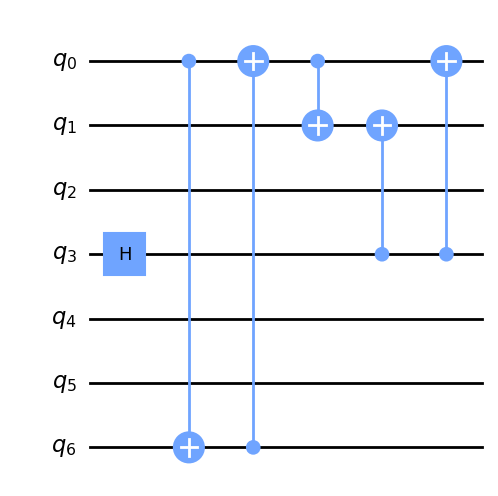

In [38]:
circuit.draw(output='mpl')

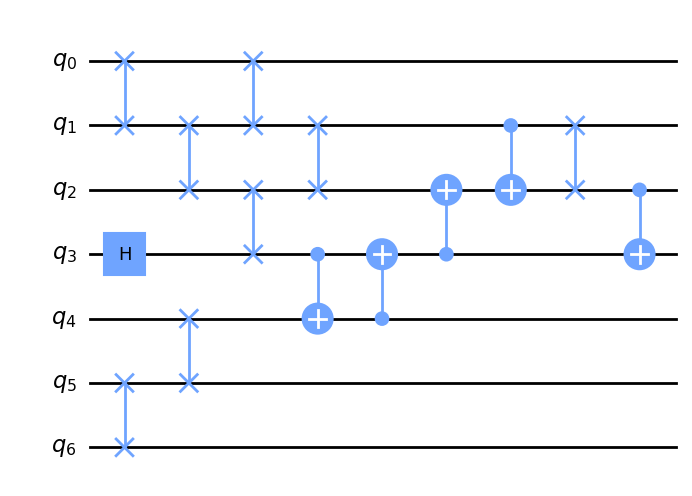

In [39]:
lookahead_circ.draw(output='mpl')

In [40]:
import math
from qiskit.providers.fake_provider import FakeHanoi

backend = FakeHanoi()

In [41]:
optimized_0 = transpile(circuit, backend=backend, seed_transpiler=11, optimization_level=0)

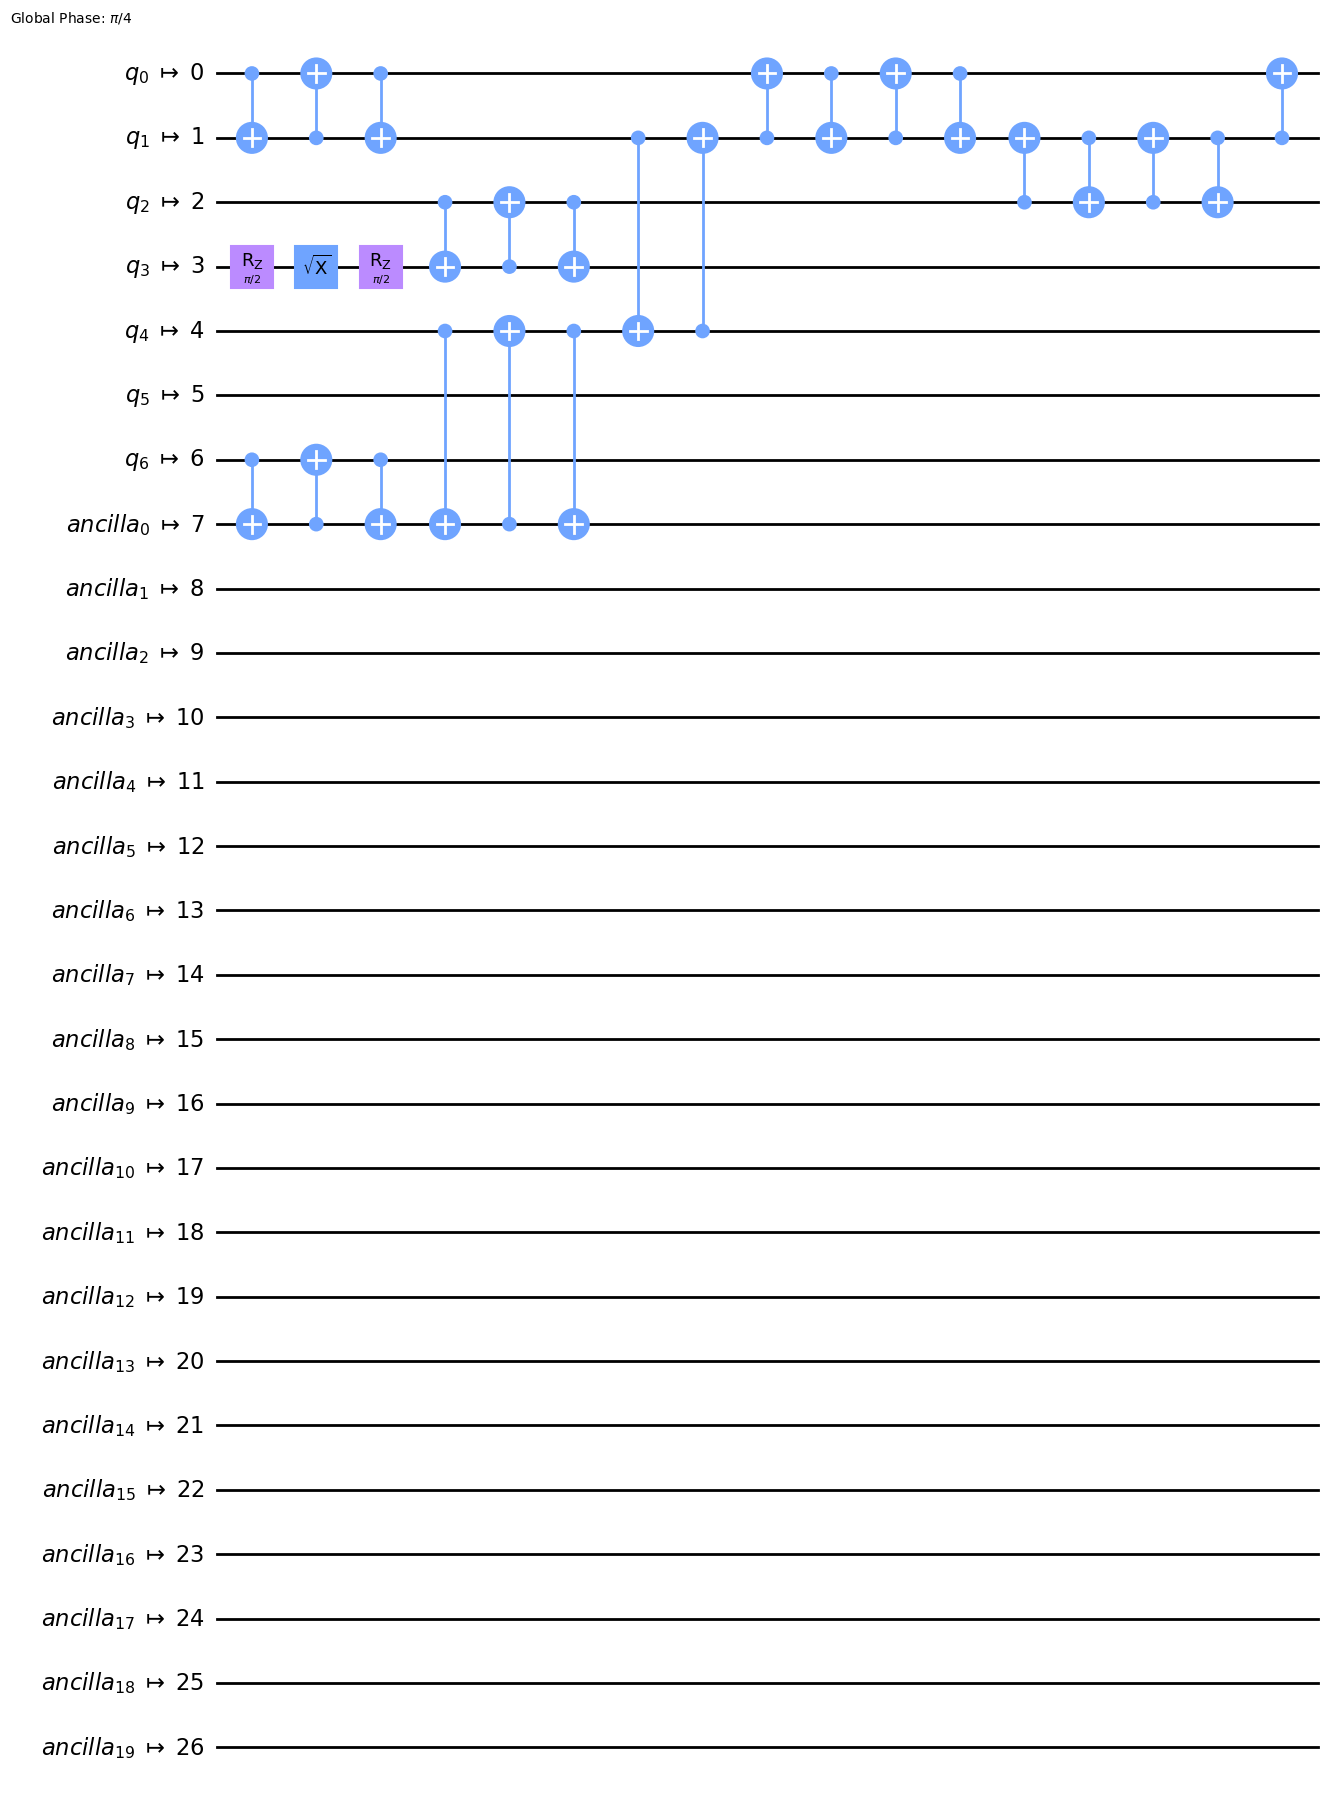

In [42]:
optimized_0.draw('mpl')

In [43]:
from qiskit.circuit.random import random_circuit
qc = random_circuit(3,2)
qc.measure_all()

In [44]:
# Select a backend to run the circuit
backend = provider.get_backend('ibmq_qasm_simulator')

result = backend.run(transpile(qc, backend), shots=1000).result()
counts  = result.get_counts(qc)
print(counts)

{'000': 98, '010': 902}


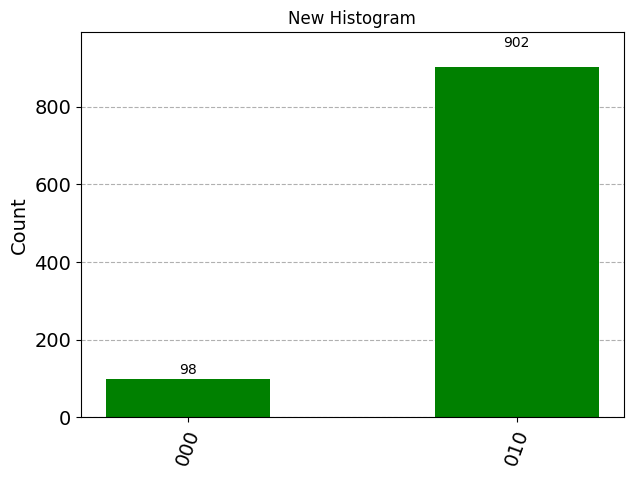

In [45]:
# Plot the result
plot_histogram(counts, color='green', title="New Histogram")

### Hands-on part

#### Try yourself

The goal is to reach the state $|-\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right)$. 

<div><img src="images/minus.png" width="200"></div>

In [ ]:
## Insert your code here
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram



In [ ]:
#BONUS VISUALIZATION
gate_colours = {
    "displaycolor": {
        "x": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "h": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "cx": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
        "ry": [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}

display(qc.draw('mpl',style=gate_colours)) 



## Some exercises on Bell states

Construct the Bell state $|\Psi^+\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle + |10\rangle\right)$.

### Solution

In [ ]:
qc = QuantumCircuit(2,2) # this time, we not only want two qubits, but also two classical bits for the measurement
#INSERT CODE HERE

Construct the other Bell states:

- $|\Psi^-\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle - |10\rangle\right)$ 
- $|\Phi^+\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + |11\rangle\right)$
- $|\Phi^+\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle - |11\rangle\right)$ 

Write a function that builds a quantum circuit on 3 qubits and creates the GHZ-like state, $|\Psi\rangle = \frac{1}{\sqrt{2}} \left(|010\rangle - |101 \rangle \right)$.

Hint: start from the circuit that constructs the GHZ state, $|GHZ\rangle = \frac{1}{\sqrt{2}} \left(|000\rangle + |111 \rangle \right)$:

## Overview of Quantum States

State-vector notation  is convenient when dealing with states that can always be expressed as a linear combination of basis states, each with an associated probability amplitude. The definition of the state of our qubits cannot always be written down as linear combinations in a given basis, sometimes it must be expressed in terms of ensembles (statistical mixtures) of multiple states (noise), each with an associated probability of occurrence. The adopted formulation is the `density matrix`. 
In the following we will review this formulation for ***pure state***, **mixed state** and we introduce the concept of **state purity** and ***partial trace***.

#### Pure State
Pure states are those for which we can precisely define their quantum state at every point in time and the measurement outcome will be probabilistic with no uncertainty on what this quantum state will be.
For example, if we initialize the single qubit $|q \rangle $ in state $ | 0 \rangle $, and apply a Hadamard gate, we know our final state will be:

$$ 
| q \rangle = \frac{1}{\sqrt{2}} \left( | 0 \rangle  + | 1 \rangle  \right) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} = | + \rangle 
$$
In general, we know that in the conventional state vector notation, an $n$-qubit pure state can be expressed as:

$$ | \psi \rangle = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_{N-1} \end{bmatrix}, $$

where $ N = 2^{n} $. An alternative way to express this pure quantum state is in the form of a matrix. This can be done by using the density operator representation, which is defined as:

$$ \rho \equiv  | \psi \rangle \langle \psi | $$

Here, the term $| \psi \rangle \langle \psi | $ represents the [outer product](../ch-gates/proving-universality.ipynb#outer) of the state $ \psi $ with itself:


$$ 
\begin{aligned}
& \rho = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_N \end{bmatrix} \begin{bmatrix} \alpha_0^* & \alpha_1^* & \dots & \alpha_N^* \end{bmatrix} 
\\
\\
& \rho = \begin{bmatrix} |\alpha_0|^2 & \alpha_0 \alpha_1^* & \dots & \alpha_0 \alpha_N^* \\ \alpha_1 \alpha_0^* & |\alpha_1|^2 & \dots & \alpha_1 \alpha_N^* \\ \vdots & \vdots & \ddots & \vdots \\ \alpha_N \alpha_0^* & \alpha_N \alpha_1^* & \dots & |\alpha_N|^2 \end{bmatrix}
\end{aligned}
$$


Let's consider, for example, the following two-qubit, maximally-entangled pure state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0 0 \rangle + | 1 1 \rangle \right ) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} 
$$


The density matrix representation for this state is then given by:

$$ 
\begin{aligned}
& \rho_{AB}  = | \psi_{AB} \rangle \langle \psi_{AB} |
\\
\\
& \rho_{AB} = \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} \right ) \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 0 & 0 & 1 \end{bmatrix} \right )
\\
\\
& \rho_{AB} = \frac{1}{2} \begin{bmatrix} 1 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 1 \\ \end{bmatrix}
\end{aligned}
$$


In Qiskit, we can use the ``quantum_info`` module to represent quantum states either in state vector notation, or in the density matrix representation. For convenience, we will import this module as ``qi``:

In [46]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

Let's once again consider the entangled pure state $| \psi_{AB} \rangle $. We can prepare this state by applying a Hadamard gate to the first qubit, and an CNOT between the first and second qubits:

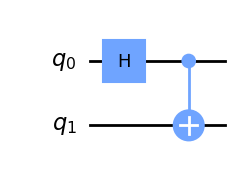

In [47]:
qc_AB = QuantumCircuit(2)
qc_AB.h(0)
qc_AB.cx(0,1)
qc_AB.draw('mpl')

To obtain the state constructed by our ``QuantumCircuit`` in state vector notation, we can make use of the ``Statevector.from_instruction()`` class method from the ``quantum_info`` module as follows:

In [48]:
psi_AB = qi.Statevector.from_instruction(qc_AB)
psi_AB.draw('latex', prefix='|\\psi_{AB}\\rangle = ')

<IPython.core.display.Latex object>

Similarly, we can use the ``DensityMatrix.from_instruction()`` class method to obtain density matrix representation for this same state:

In [49]:
rho_AB = qi.DensityMatrix.from_instruction(qc_AB)
rho_AB.draw('latex', prefix='\\rho_{AB} = ')

<IPython.core.display.Latex object>

As expected, the result matches our calculation. We can also visualize the density matrix using a cityscape plot of the state:

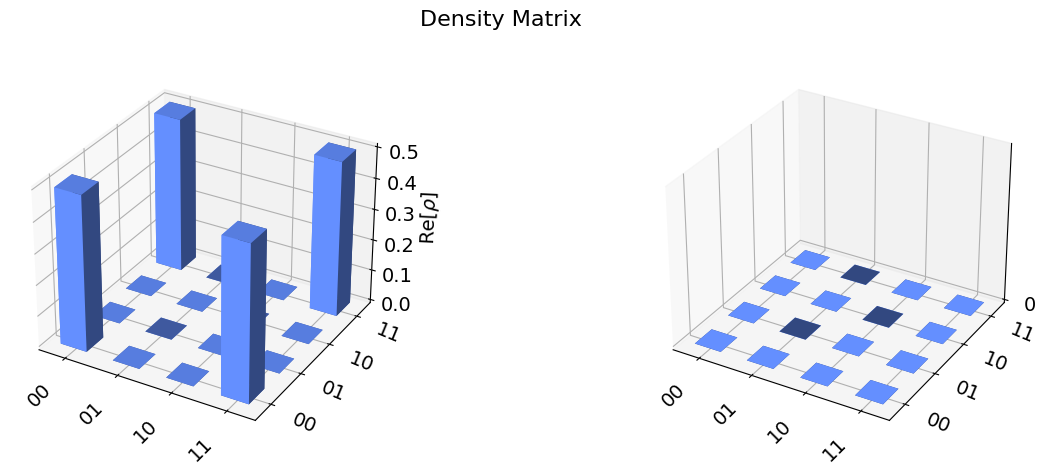

In [50]:
from qiskit.visualization import plot_state_city
plot_state_city(rho_AB.data, title='Density Matrix')

### 1. Exercises  <a id="ex1"></a>
Find the corresponding density matrix for the following pure states. Use Qiskit to prepare the states, and verify your results using the ``quantum_info`` module:
   	
$$ 
\frac{1}{2}\left ( |0 0 \rangle + |0 1 \rangle + |1 0 \rangle + |1 1 \rangle \right ) 
$$       



# Device backend noise model simulations

In the following we show how to use the Qiskit Aer `noise` module to automatically generate a basic noise model for an IBMQ hardware device, and use this model to do noisy simulations of `QuantumCircuits` to study the effects of errors which occur on real devices.

Note, that these automatic models are only an *approximation* of the real errors that occur on actual devices, due to the fact that they must be build from a limited set of input parameters related to *average error rates* on gates. The study of quantum errors on real devices is an active area of research and we discuss the Qiskit Aer tools for configuring more detailed noise models in another notebook.

In [51]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

## Device Backend Noise Model

The *Qiskit Aer* device noise model automatically generates a simplified noise model for a real device. This model is generated using the calibration information reported in the `BackendProperties` of a device and takes into account

* The *gate_error* probability of each basis gate on each qubit.
* The *gate_length* of each basis gate on each qubit.
* The $T_1$, $T_2$ relaxation time constants of each qubit.
* The readout error probability of each qubit.

### Terra Mock  Backends

We will use real noise data for an IBM Quantum device using the data stored in Qiskit Terra. Specifically, in this tutorial, the device is `ibmq_vigo`.

In [52]:
from qiskit.providers.fake_provider import FakeVigo

device_backend = FakeVigo()

### Test circuit for device and simulation comparison

Now we construct a test circuit to compare the output of the real device with the noisy output simulated on the Qiskit Aer `AerSimulator`. We will prepare a 3-qubit GHZ state $\frac{1}{\sqrt2}(|0,0,0\rangle + |1,1,1\rangle)$ on qubits 0, 1 and 2. Before running with noise or on the device we show the ideal expected output with no noise.

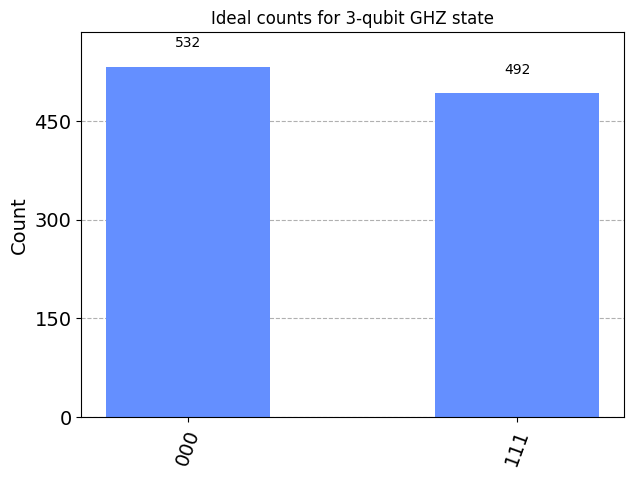

In [53]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

## Generating a simulator that mimics a device

We call `from_backend` to create a simulator for `ibmq_vigo`:

In [54]:
sim_vigo = AerSimulator.from_backend(device_backend)

By storing the device properties in `vigo_simulator`, we ensure that the appropriate basis gates and coupling map are used when compiling circuits for simulation, thereby most closely mimicking the gates that will be executed on a real device. In addition `vigo_simulator` contains an approximate noise model consisting of:

* **Single-qubit gate errors** consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.
* **Two-qubit gate errors** consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
* **Single-qubit readout errors** on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the `thermal_relaxation_error` function from `aer.noise.errors` module, along with the individual qubit $T_1$ and $T_2$ parameters, and the `gate_time` parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the `gate_error` value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit `readout_errors`.

### Running a noise simulation

Once we have created a noisy simulator backend based on a real device we can use it to run noisy simulations.

**Important:** When running noisy simulations it is *critical* to `transpile` the circuit for the backend so that the circuit is transpiled to the correct noisy basis gate set for the backend.

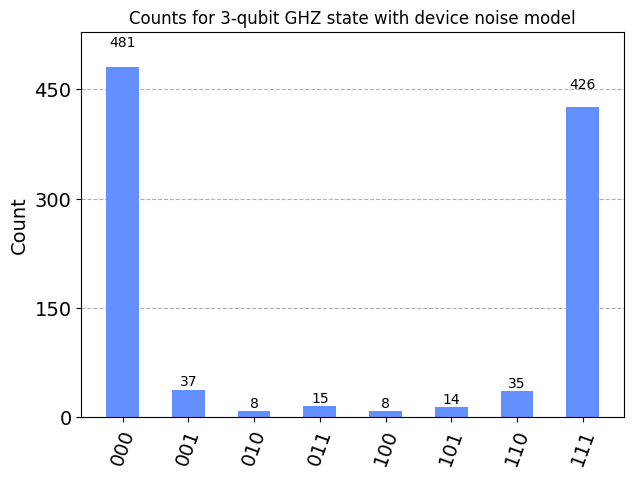

In [55]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

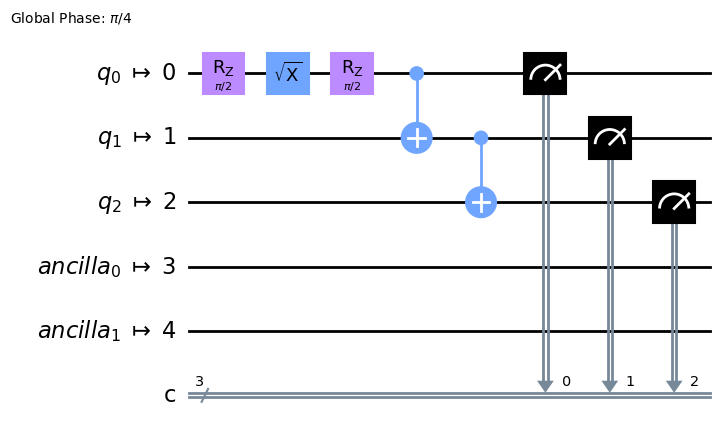

In [56]:
tcirc.draw('mpl')

If transpilation is skipped noise from the device noise model will not be applied to gates in the circuit that are supported by the simulator, but not supported by the mimicked backend.